# Online Phase: POD with Interpolation

This notebook implements the online phase of the following algorithms:

- Proper Orthogonal Decomposition with Interpolation (POD-I)

In particular, the maps between parameter and reduced coefficients is used to reconstruct the full-order field, for unseen parameters.

In [1]:
import gmsh
import os
from IPython.display import clear_output
import numpy as np
import pickle

from dolfinx.fem import FunctionSpace
from pyforce.online.pod_interpolation import PODI
from pyforce.online.pod_projection import POD_project
import ufl

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

from mpi4py import MPI
from dolfinx.io import gmshio

from pyforce.tools.functions_list import FunctionsList, train_test_split
from pyforce.tools.write_read import ImportH5


path_off ='./Offline_results/'

The geometry is imported from "cyk_dfg2D.geo", generated with GMSH. Then, the mesh is created with the gmsh module.

In [2]:
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh_factor = .35

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('cyl_dfg2D.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)
gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)
gdim = 2

# Linear Finite Element
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

clear_output()

# Import into dolfinx
model_rank = 0
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, model_rank, gdim = gdim )

ft.name = "Facet markers"

bound_markers = dict()
bound_markers['inlet']     = 1
bound_markers['walls']     = 2
bound_markers['outlet']    = 3
bound_markers['obstacle']  = 4

domain_marker = 10

domain.topology.create_connectivity(gdim, gdim)
domain.topology.create_connectivity(gdim-1, gdim)

# Finalize the gmsh module
gmsh.finalize()

## Importing Snapshots and offline results

The snapshots are loaded and stored into suitable data structures.

In [3]:
# Defining the functional space
fun_spaces = [FunctionSpace(domain, ("Lagrange", 1)),
              FunctionSpace(domain, ufl.VectorElement("Lagrange", domain.ufl_cell(), 1))]

# Define the variables to load
var_names = [
             'p',
             'u'
             ]

tex_var_names = [
                 r'p',
                 r'\mathbf{u}'
                 ]

stored_var_names = [
                    'p',
                    'U'
                    ]


# Snapshot path
path_FOM = './Snapshots/'

################ Importing Snapshots ########################
# train_snaps = list()
test_snaps  = list()

# train_params = list()
test_params  = list()

for field_i in range(len(var_names)):

    tmp_FOM_list, tmp_param = ImportH5(fun_spaces[field_i], path_FOM+'snaps_'+var_names[field_i], stored_var_names[field_i])
    
    res = train_test_split(tmp_param, tmp_FOM_list, test_size=0.25)
    
    # train_params.append(res[0])
    test_params.append(np.array(res[1]).reshape(-1,1))
    
    # train_snaps.append(res[2])
    test_snaps.append(res[3])
    
    del tmp_FOM_list, tmp_param

The POD modes are loaded using `ImportH5`.

In [4]:
pod_modes = [ImportH5(fun_spaces[field_i], 
                      path_off+'BasisFunctions/basisPOD_' + var_names[field_i],
                      'POD_' +var_names[field_i])[0] for field_i in range(len(var_names))]

Then, let us import the maps $t\longrightarrow \alpha_m(t)$

In [5]:
coeff_maps = pickle.load(open(path_off+'pod_coeff.maps', 'rb'))

## Online Phase
The test set related to unseen parameters are reconstruction using the Proper Orthogonal Decomposition with Intepolation, compared with the projection case.

### Test Error
Let us first define the structures for storing the errors

In [6]:
test_errors = dict()
Nmax = 25

At first, let us reconstruct the field using the POD projection, the coefficients are obtained by means of the following projection (scalar product in $L^2$):
\begin{equation}
\alpha_m(\boldsymbol{\mu}) = \int_{\Omega} u(\mathbf{x}; \boldsymbol{\mu})\cdot \psi_m\, d\Omega
\end{equation}

In [7]:
pod_proj_online = [POD_project(pod_modes[field_i], name=var_names[field_i]) for field_i in range(len(var_names))]
test_errors['POD-Project'] = [pod_proj_online[field_i].synt_test_error(test_snaps[field_i], Nmax, verbose=True) for field_i in range(len(var_names))]

Computing POD test error (projection) - p: 40.000 / 40.00 - 0.024 s/it
Computing POD test error (projection) - u: 40.000 / 40.00 - 0.033 s/it


Then, let us use the POD with Interpolation in which the coefficients $\alpha_m(t)$ are estimated through a suitable map (e.g., interpolation)

In [8]:
pod_i_online = dict()
for key_i, key in enumerate(list(coeff_maps[0].keys())):
    pod_i_online[key] = [PODI(pod_modes[field], coeff_maps[field][key], name=var_names[field]) for field in range(len(var_names))]
    
    test_errors['POD-'+key] = [pod_i_online[key][field_i].synt_test_error(test_snaps[field_i], test_params[field_i], Nmax, verbose=True) for field_i in range(len(var_names))]

Computing POD test error (interpolation) - p: 40.000 / 40.00 - 0.015 s/it
Computing POD test error (interpolation) - u: 40.000 / 40.00 - 0.020 s/it
Computing POD test error (interpolation) - p: 40.000 / 40.00 - 0.015 s/it
Computing POD test error (interpolation) - u: 40.000 / 40.00 - 0.020 s/it


Let us plot the error as a function of the basis rank

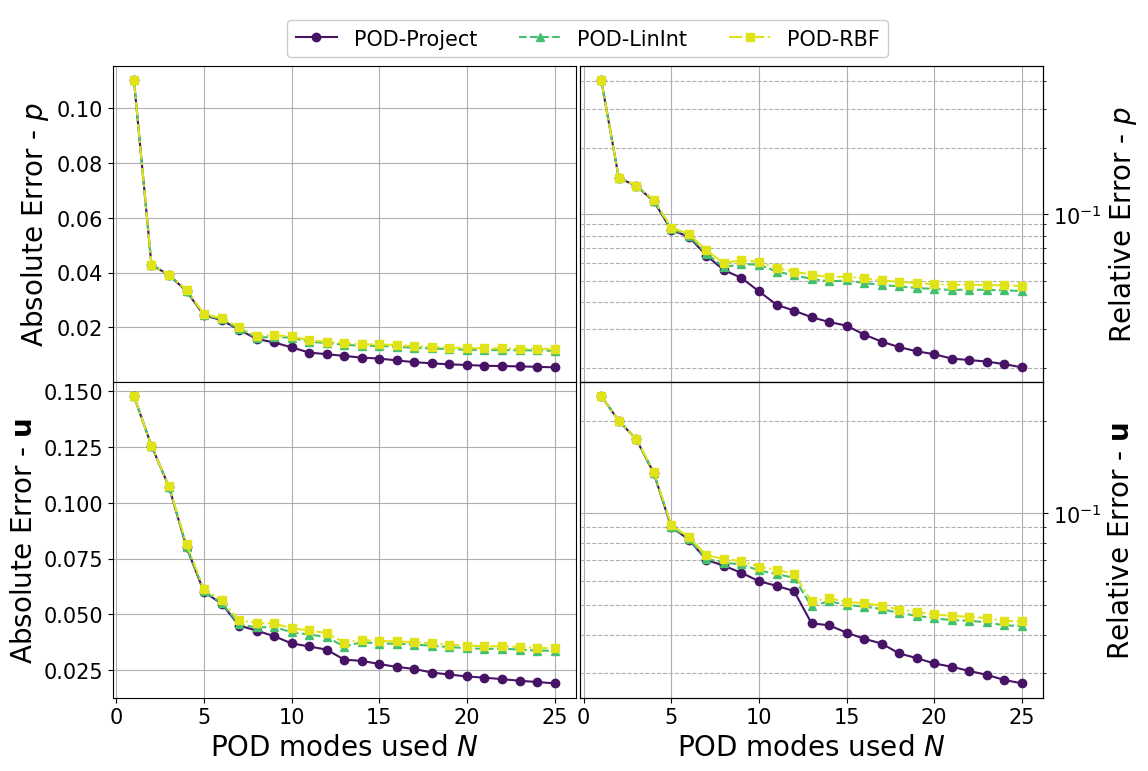

In [9]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=True, figsize=(2 * 6, 2*4))

N_plot = np.arange(1, Nmax+1, 1)
fontsize  = 20
labelsize = 15

markers = ['o', '^', 's']
lines_style = ['-', '--', '-.']
colors = cm.viridis([0.05, 0.7, 0.95])

for field_i in range(len(var_names)):
    
    ax2 = axs[field_i, 1].twinx()
    for ii, key in enumerate(list(test_errors.keys())):
        axs[field_i, 0].plot(N_plot, test_errors[key][field_i][0], markers[ii]+lines_style[ii], c=colors[ii], label=key)
        ax2.semilogy(N_plot, test_errors[key][field_i][1], markers[ii]+lines_style[ii], c=colors[ii], label=key)
        
    axs[field_i, 0].set_ylabel(r'Absolute Error - $'+tex_var_names[field_i]+r'$', fontsize=fontsize)
    ax2.set_ylabel(r'Relative Error - $'+tex_var_names[field_i]+r'$', fontsize=fontsize)
    
    axs[field_i, 0].grid(which='major',linestyle='-')
    axs[field_i, 0].grid(which='minor',linestyle='--')
    axs[field_i, 1].set_yticks([])
    axs[field_i, 1].grid(which='major',linestyle='-')
    axs[field_i, 1].grid(which='minor',linestyle='--')   
    ax2.grid(which='major',linestyle='-')
    ax2.grid(which='minor',linestyle='--')   
    ax2.tick_params(axis='both', labelsize=labelsize)

for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=labelsize)
axs[1, 0].set_xlabel(r'POD modes used $N$', fontsize=fontsize)
axs[1, 1].set_xlabel(r'POD modes used $N$', fontsize=fontsize)    


Line, Label = axs[0,0].get_legend_handles_labels()    
fig.legend(Line, Label, framealpha = 1, fontsize=labelsize, loc=(0.25, 0.925), ncols=3)

fig.subplots_adjust(hspace = 0.0, wspace=0.01, top=0.9)

Let us also plot the computational costs

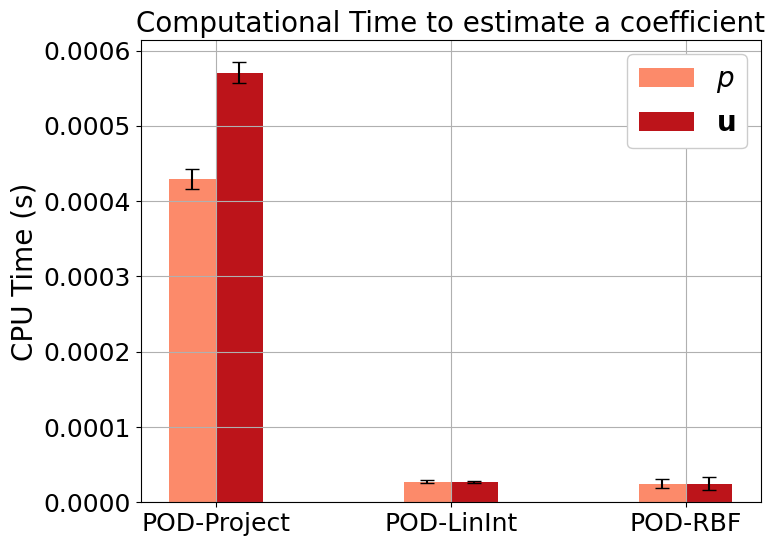

In [10]:
# Initialize subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate over field_i values
colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(var_names)))  # Choose a colormap
for field_i, color in zip(range(len(var_names)), colors):
    means = []
    stds = []

    # Calculate mean and std for each key
    for key in list(test_errors.keys()):
        mean = np.mean(np.mean(test_errors[key][field_i][2]['CoeffEstimation'], axis=0))
        std = np.std(np.mean(test_errors[key][field_i][2]['CoeffEstimation'], axis=0))
        means.append(mean)
        stds.append(std)

    # Plot the bar chart with error bars for standard deviation
    bar_width = 0.2  # Adjust as needed
    ind = np.arange(len(list(test_errors.keys())))
    bars = ax.bar(ind + (field_i - len(var_names) / 4) * bar_width, means, bar_width, label=r'$'+tex_var_names[field_i]+'$', color=color, yerr=stds, capsize=5)

ax.set_ylabel(r'CPU Time (s)', fontsize=20)
ax.set_title(r'Computational Time to estimate a coefficient', fontsize=20)
ax.set_xticks(ind)
ax.set_xticklabels(list(test_errors.keys()))
ax.legend(framealpha=1, fontsize=20)
ax.tick_params(axis='both', labelsize=18)
ax.grid()

### Post Process
In this last section, the test snapshots and the reconstruction using POD-I are plotted using `pyvista`. 

In [11]:
Nmax = 15
keys = list(test_errors.keys())

reconstructions = list()

for field_i in range(len(var_names)):
    reconstructions.append(dict())
    
    for key in keys:   
        reconstructions[field_i][key] = FunctionsList(fun_spaces[field_i])
        
    for mu in range(len(test_snaps[field_i])):
        reconstructions[field_i][keys[0]].append(pod_proj_online[field_i].reconstruct(test_snaps[field_i](mu), Nmax)[0])
        
        for jj in range(1, len(keys)):
            reconstructions[field_i][keys[jj]].append(pod_i_online[keys[jj][4:]][field_i].reconstruct(test_snaps[field_i](mu), test_params[field_i][mu].reshape(-1,1), Nmax)[0])

Let us assert the drag, lift and pressure difference with respect to FOM and benchmark data.

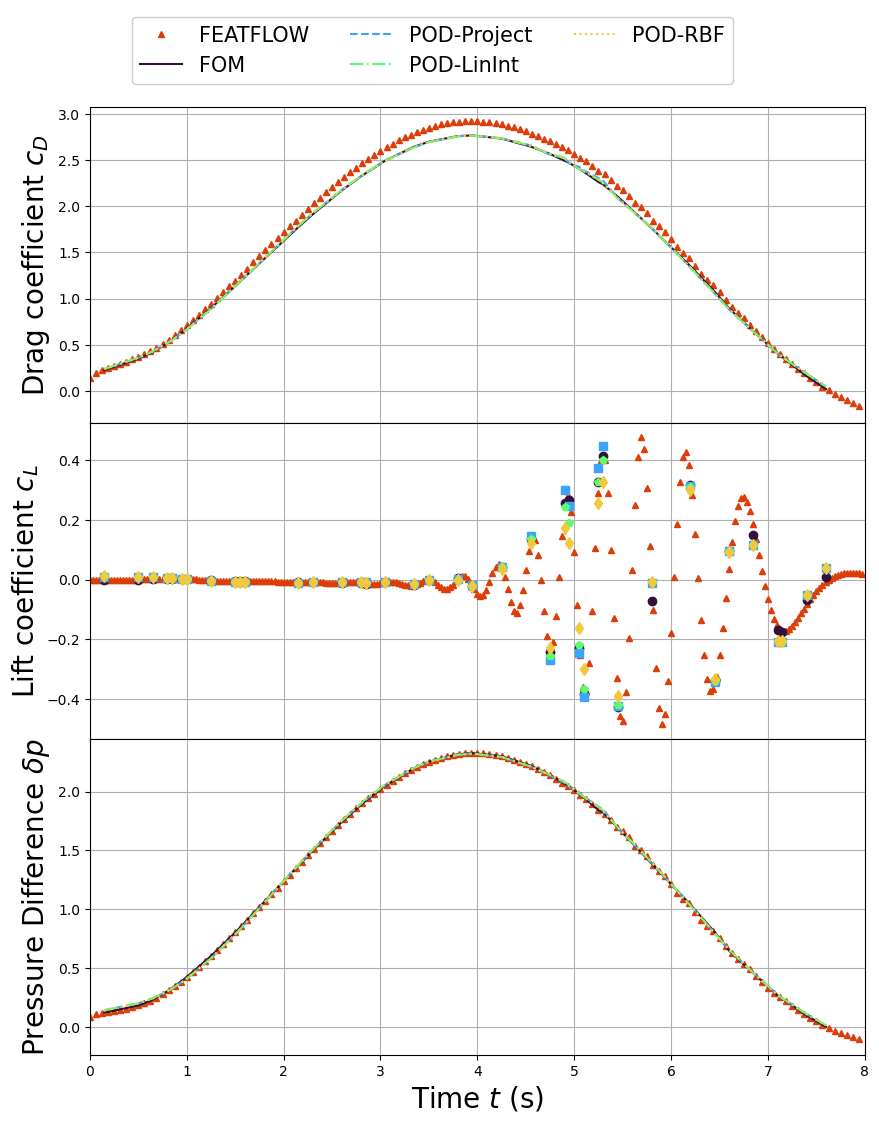

In [57]:
from ns import drag_lift
from dolfinx.fem import Function, Expression

T = 8
dt = 5.00e-4                # Time step size

params = {'nu': 1e-3, 'rhoLU2': 0.1}




QoI_data = list()

def compute_d_l(p_snaps: FunctionsList, u_snaps: FunctionsList):

    V2 = FunctionSpace(domain, ufl.VectorElement("Lagrange", domain.ufl_cell(), 2))
    u2 = Function(V2)
    get_drag_lift = drag_lift(domain, ft, params, bound_markers['obstacle'])
    for mu in np.argsort(test_params[field_i].flatten()):    
        mu = int(mu)
        u2.interpolate(Expression(u_snaps.map(mu), V2.element.interpolation_points()))
        get_drag_lift.compute(test_params[field_i][mu], dt, u2, p_snaps.map(mu))
        
    _data = dict()
    _data['t_u'] = get_drag_lift.t_u
    _data['t_p'] = get_drag_lift.t_p
    _data['C_D'] = get_drag_lift.C_D
    _data['C_L'] = get_drag_lift.C_L
    _data['dP']  = get_drag_lift.p_diff
    
    return _data

# FOM calculation
QoI_data.append(compute_d_l(*test_snaps))

# ROM calculation
for key in list(reconstructions[0].keys()):
    QoI_data.append(compute_d_l(reconstructions[0][key], reconstructions[1][key]))
    
    
############### PLOTTING ###############
turek = np.loadtxt("Benchmark_Data/bdforces_lv4.txt")
turek_p = np.loadtxt("Benchmark_Data/pointvalues_lv4.txt")

keys = ['FOM', *list(reconstructions[0].keys())]
colors = cm.turbo(np.linspace(0., 0.85, len(keys)+1))
markers_styles = ['o', 's', 'p', 'd']
line_styles = ['-', '--', '-.', ':']

fig, axs = plt.subplots(3,1, sharex=True, figsize=(10, 12))

# Drag Coefficient
axs[0].plot(turek[1:,1], turek[1:,3], "^", color=colors[-1], markevery=100, markersize=5, label="FEATFLOW")
for kk in range(len(keys)):
    axs[0].plot(QoI_data[kk]['t_u'], QoI_data[kk]['C_D'], line_styles[kk], color=colors[kk], label=keys[kk])
axs[0].set_ylabel(r"Drag coefficient $c_D$", fontsize=20)
axs[0].grid()

# Lift Coefficient
axs[1].plot(turek[1:,1], turek[1:,4], "^", color=colors[-1], markevery=50, markersize=5, label="FEATFLOW")
for kk in range(len(keys)):
    axs[1].plot(QoI_data[kk]['t_u'], QoI_data[kk]['C_L'], markers_styles[kk], color=colors[kk], label=keys[kk])
axs[1].set_ylabel(r"Lift coefficient $c_L$", fontsize=20)
axs[1].grid()

# Pressure Difference
axs[2].plot(turek[1:,1], turek_p[1:,6]-turek_p[1:,-1], "^", color=colors[-1], markevery=100, markersize=5, label="FEATFLOW")
for kk in range(len(keys)):
    axs[2].plot(QoI_data[kk]['t_p'], QoI_data[kk]['dP'], line_styles[kk], color=colors[kk], label=keys[kk])
axs[2].set_ylabel(r"Pressure Difference $\delta p$", fontsize=20)
axs[2].set_xlabel(r"Time $t$ (s)", fontsize=20)
axs[2].grid()
axs[2].set_xlim(0,T)


Line, Label = axs[0].get_legend_handles_labels()    
fig.legend(Line, Label, framealpha = 1, fontsize=labelsize, loc=(0.15, 0.925), ncols=3)

fig.subplots_adjust(hspace = 0.0, wspace=0.0, top=0.9)

Here some auxiliary plotting functions are defined

In [15]:
import vtk
import pyvista as pv
import dolfinx

pv.start_xvfb()

def vector_grids(fun: dolfinx.fem.Function, mag_plot: bool, varname='u'):
    
    topology, cells, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    grid = pv.UnstructuredGrid(topology, cells, geometry)

    values = np.zeros((geometry.shape[0], 3))
    values[:, :len(fun)] = np.real(fun.x.array.reshape(geometry.shape[0], len(fun)))
    grid[varname] = values

    if mag_plot:
        warped = grid.warp_by_vector(varname, factor=0.0) 
    else:
        warped = grid.glyph(varname, factor=0.15, tolerance=0.02)
        
    return warped, values

def grids(fun: dolfinx.fem.Function):
    topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    u_grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    u_grid.point_data['fun'] = fun.x.array[:].real
    u_grid.set_active_scalars('fun')
    return u_grid

Here we define the plotting function

In [16]:
def PlotFOM_vs_ROM( fom: FunctionsList, rom: dict, mu: int, title: str, varname: str,
                    clim = None, mag_plot = True, colormap = cm.jet, 
                    colormap_res = cm.plasma_r, clim_res = None,
                    filename = None):  
    
    keys = list(rom.keys())
    
    resolution = [1800, 400 * ( len(keys) + 1)]
    plotter = pv.Plotter(shape=(len(keys)+1, 2), off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 25
    title_fontsize = 35
    zoom = 2.25
    
    dict_cb = dict(title = varname, width = 0.75, height = 0.2,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    n_labels=3,
                    color = 'k',
                    position_x=0.125, position_y=0.745,
                    shadow=False) 
    
    if test_snaps[field_i].fun_space.num_sub_spaces > 0:
        vector_plot = True
    else:
        vector_plot = False
    
    ############################ FOMs ###################################

    plotter.subplot(0,0)
    
    if vector_plot:
        warped_fom, values_fom = vector_grids(fom.map(mu), mag_plot, varname=varname)
        if clim is None:
            clim = [0., max(np.sqrt(values_fom[:, 0]**2+values_fom[:, 1]**2+values_fom[:, 2]**2))]
    else:
        warped_fom = grids(fom.map(mu))
        if clim is None:
            clim = [min(fom(mu)), max(fom(mu))]
        
    dict_cb['title'] = 'FOM - $'+varname+'$'
    plotter.add_mesh(warped_fom, clim = clim, cmap = colormap, show_edges=False, scalar_bar_args=dict_cb)
    plotter.view_xy()
    plotter.camera.zoom(zoom)

    ############################ ROMs ###################################


    for key_i in range(len(keys)):
        plotter.subplot(1+key_i,0)
        
        # rom[keys[key_i]]._list[mu] = rom[keys[key_i]]._list[mu] * (umax - umin) + umin
    
        if vector_plot:
            warped_rom, _ = vector_grids(rom[keys[key_i]].map(mu), mag_plot, varname=varname)
        else:
            warped_rom = grids(rom[keys[key_i]].map(mu))
        
        dict_cb['title'] = keys[key_i]+' - $'+varname+'$'
        plotter.add_mesh(warped_rom, clim = clim, cmap = colormap, show_edges=False, scalar_bar_args=dict_cb)
        plotter.view_xy()
        plotter.camera.zoom(zoom)

    ############################ Residuals ###################################

    max_res = 0.
    for key_i in range(len(keys)):
        plotter.subplot(1+key_i,1)
        
        residual = dolfinx.fem.Function(rom[keys[key_i]].fun_space)
        residual.x.array[:] = np.abs(rom[keys[key_i]](mu) - fom(mu))

        max_res = max([max_res, max(residual.x.array[:])])
        
        if vector_plot:
            warped_rom, _ = vector_grids(residual, mag_plot, varname=varname)
        else:
            warped_rom = grids(residual)
        
        if clim_res is None:
            clim_res = [0, max_res]
        
        dict_cb['title'] = 'Residual '+keys[key_i]+' - $'+varname+'$'
        plotter.add_mesh(warped_rom, clim = clim_res, cmap = colormap_res, show_edges=False, scalar_bar_args=dict_cb)
        plotter.view_xy()
        plotter.camera.zoom(zoom)


    plotter.set_background('white', top='white')
    plotter.subplot(0,1)
    plotter.add_text(str(title), color= 'k', position=[250, 200], font_size=30)
    
    if filename is None:
        plotter.show()
    else:
        ## Save figure
        plotter.screenshot(filename+'.png', transparent_background = True,  window_size=resolution)
        plotter.close()

In the end, the figure can be generated

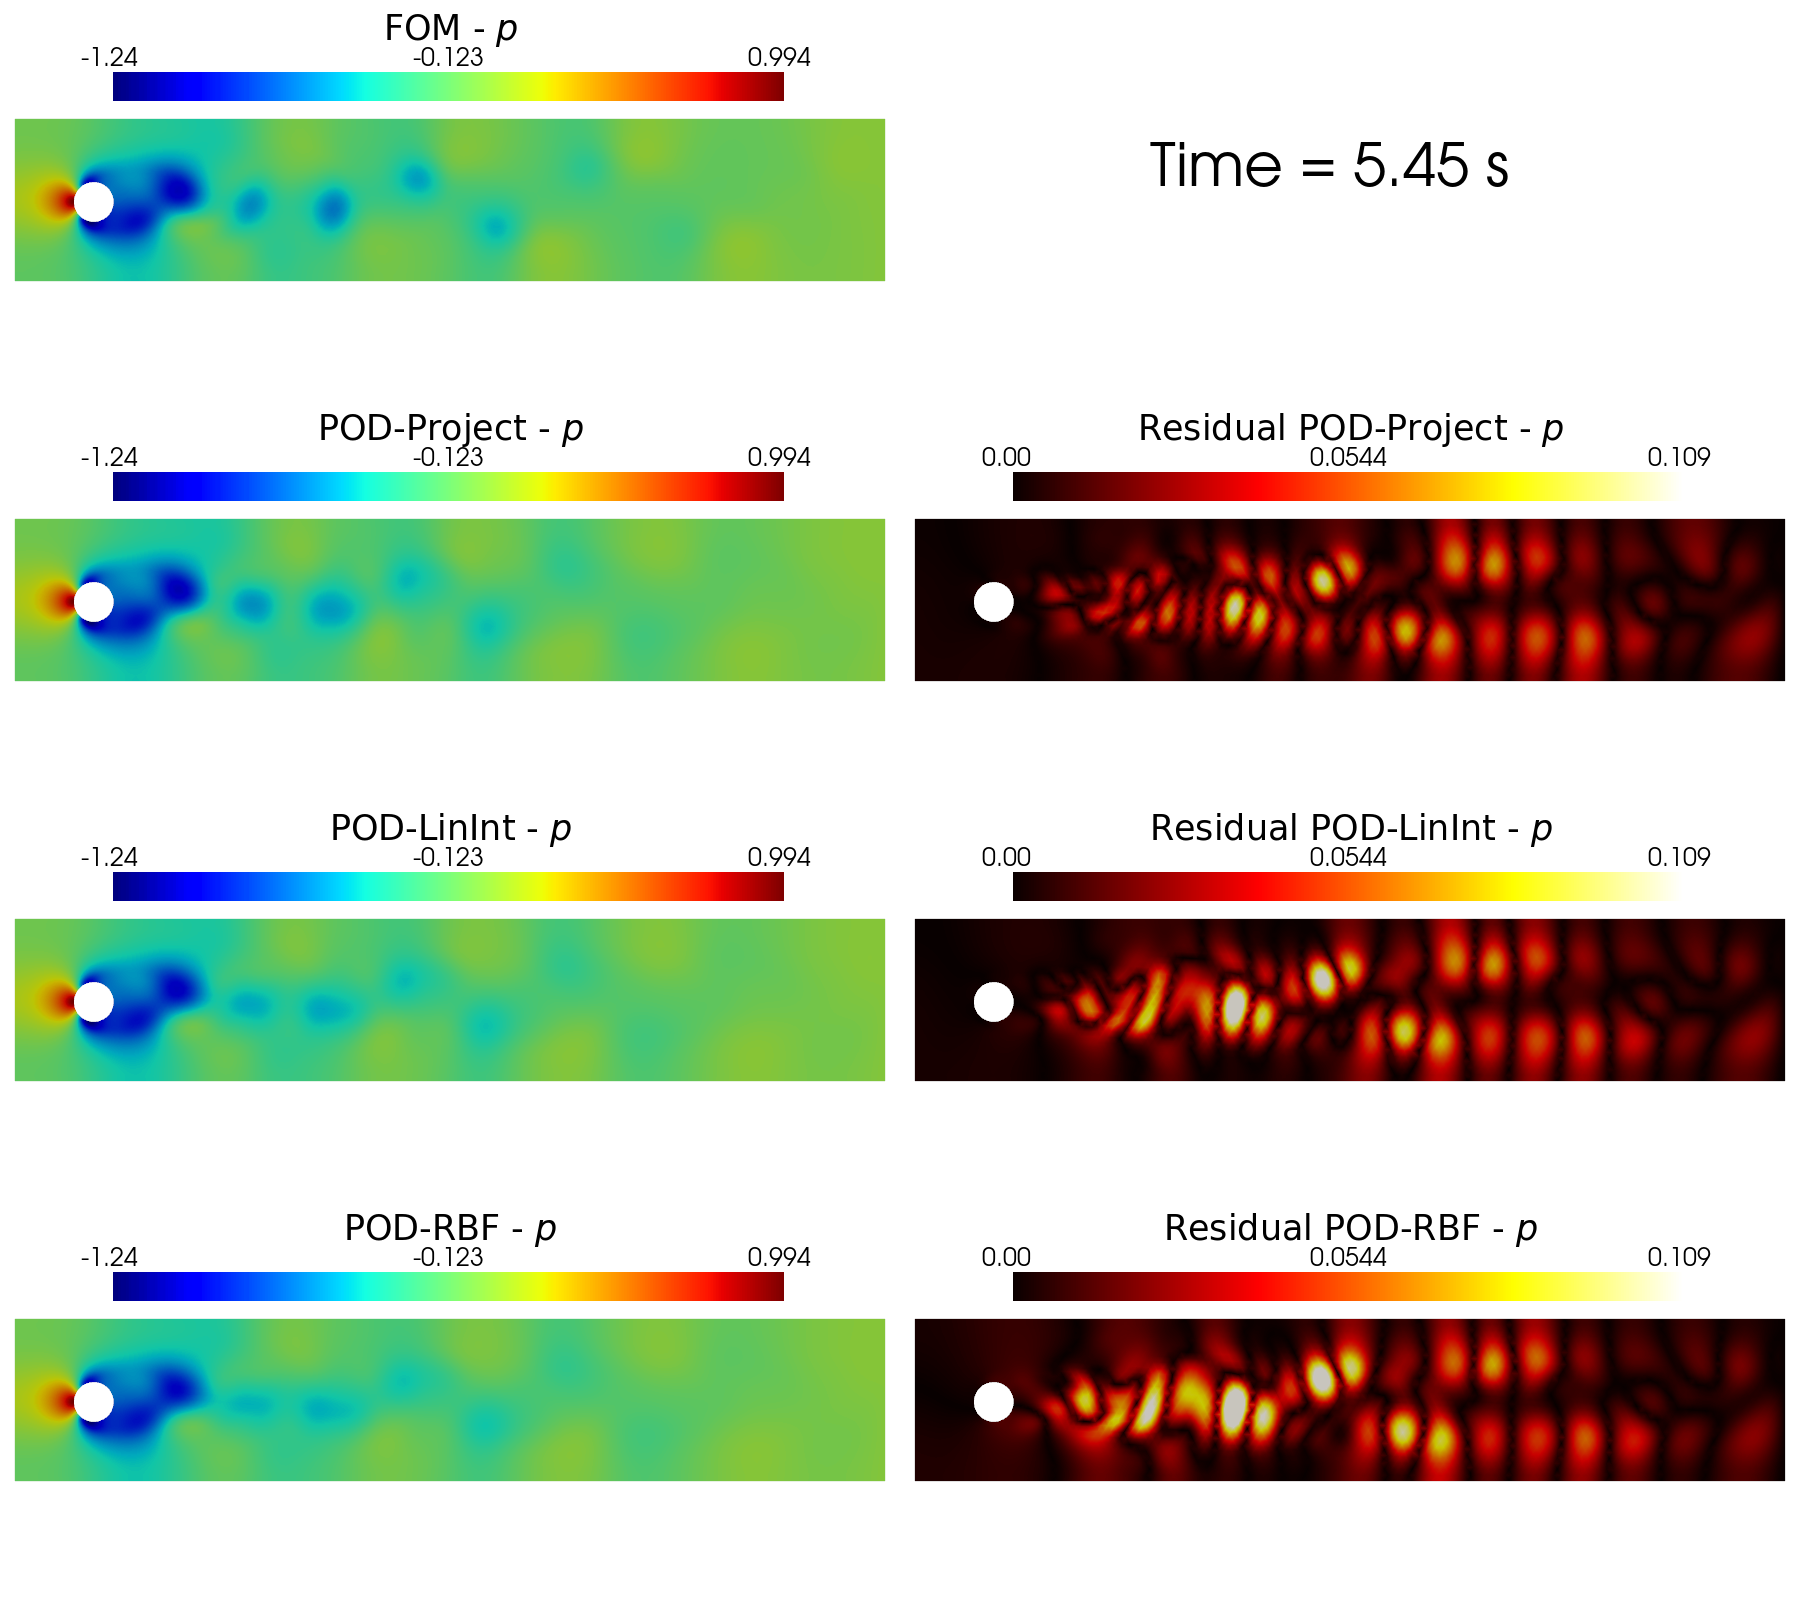

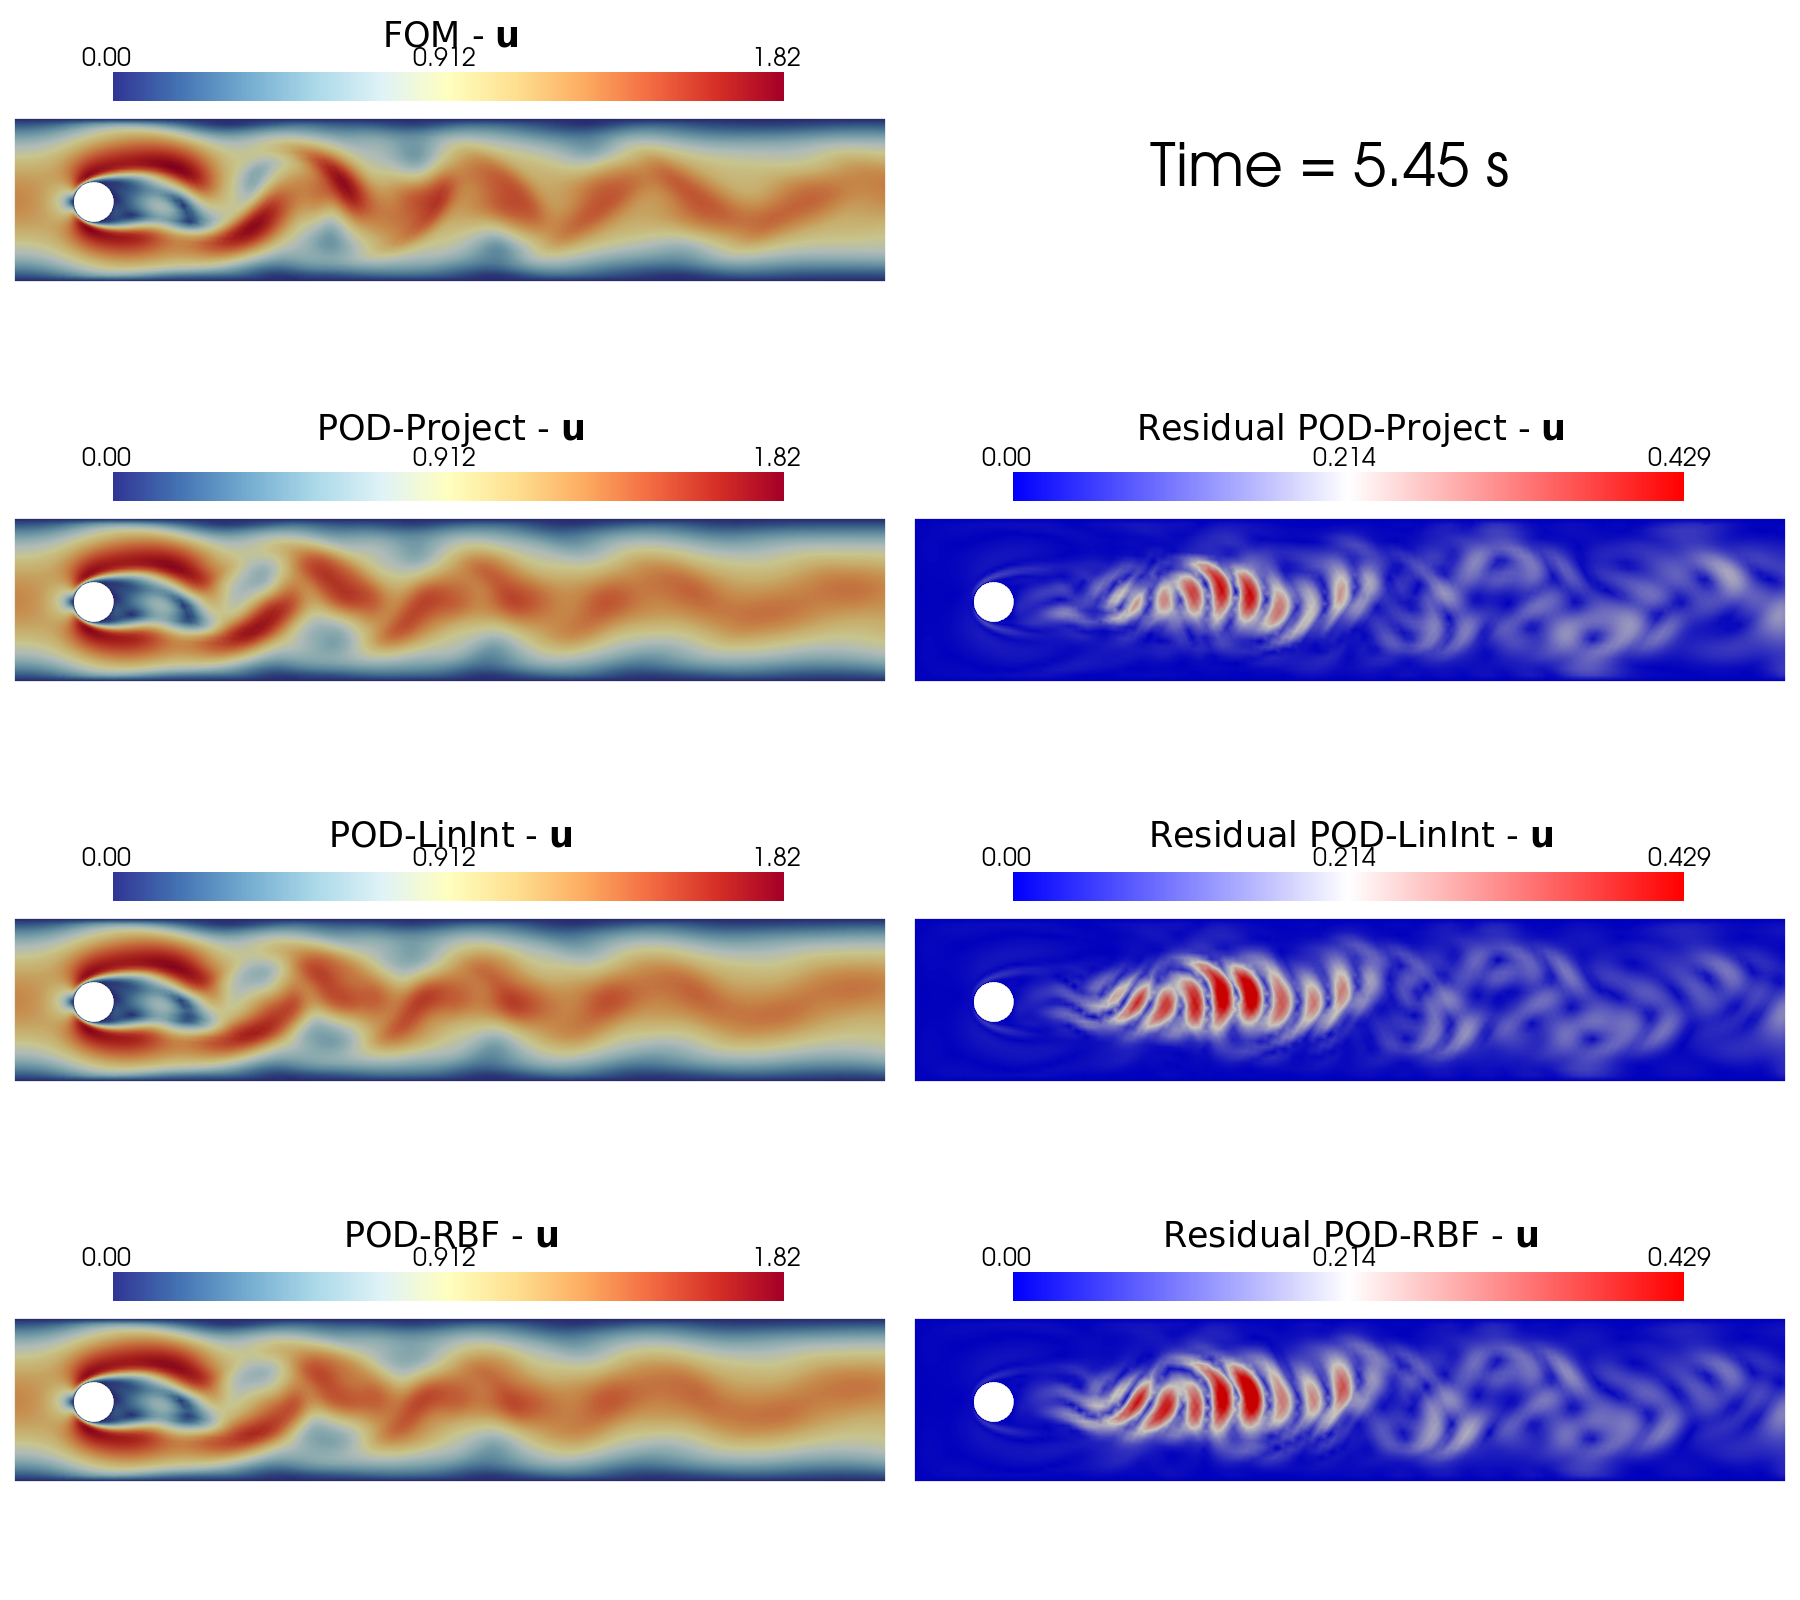

In [19]:
from pyforce.tools.backends import LoopProgress

sorted_idx = np.argsort(test_params[0].flatten())


make_video = False
if make_video:
    path='./Online_results/'
    if not os.path.exists(path):
        os.makedirs(path)
    
cmaps = [cm.jet, cm.RdYlBu_r]
cmaps_res = [cm.hot, cm.bwr]


for field_i in range(len(var_names)):
    bar = LoopProgress('Plotting '+var_names[field_i], final = len(sorted_idx))
    
    if make_video:
        for tt_plot in sorted_idx:
            title = 'Time = {:.2f}'.format(test_params[field_i].flatten()[tt_plot])+' s'

            PlotFOM_vs_ROM( test_snaps[field_i], reconstructions[field_i], 
                            tt_plot, title, tex_var_names[field_i],
                            colormap=cmaps[field_i], colormap_res = cmaps_res[field_i],
                            filename=path+var_names[field_i]+'_time_{:.2f}'.format(test_params[field_i].flatten()[tt_plot])
                            )
            bar.update(1)
        del bar
    else:
        for tt_plot in [sorted_idx[30]]:
            title = 'Time = {:.2f}'.format(test_params[field_i].flatten()[tt_plot])+' s'

            PlotFOM_vs_ROM( test_snaps[field_i], reconstructions[field_i], 
                            tt_plot, title, tex_var_names[field_i],
                            colormap=cmaps[field_i], colormap_res = cmaps_res[field_i],
                            filename=None
                            )

In [15]:
# Command to insert a video in HTML
# <video controls src="Online_results/prova.mov" />